In [ ]:
from sklearn import datasets

digits = datasets.load_digits()

In [ ]:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target == 8
print(
    f"The number of images is {X.shape[0]} and each image contains {X.shape[1]} pixels"
)

The number of images is 1797 and each image contains 64 pixels


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [ ]:
scores = ["precision", "recall"]

In [ ]:
import pandas as pd


def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()


def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.98, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.98

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

tuned_parameters = [
    {"kernel": ["rbf"], "gamma": [1e-3, 1e-4], "C": [1, 10, 100, 1000]},
    {"kernel": ["linear"], "C": [1, 10, 100, 1000]},
]

grid_search = GridSearchCV(
    SVC(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train, y_train)

All grid-search results:
precision: 1.000 (±0.000), recall: 0.854 (±0.063), for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.257 (±0.061), for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.877 (±0.069), for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.968 (±0.039), recall: 0.780 (±0.083), for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.877 (±0.069), for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.905 (±0.058), recall: 0.889 (±0.074), for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 1.000 (±0.000), recall: 0.877 (±0.069), for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
precision: 0.904 (±0.058), recall: 0.890 (±0.073), for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
precision: 0.695 (±0.073), recall: 0.743 (±0.065), for {'C': 1, 'kernel': 'linear'}
precision: 0.643 (±0.066), recall: 0.757 (±0.066), for {'C': 10, 'kernel': 'linear'}
precision: 0.6

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning:

invalid value encountered in cast



GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             refit=<function refit_strategy at 0x7cfaeb4efac0>,
             scoring=['precision', 'recall'])

In [ ]:
grid_search.best_params_

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

In [ ]:
from sklearn.metrics import classification_report

y_pred = grid_search.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99       807
        True       1.00      0.87      0.93        92

    accuracy                           0.99       899
   macro avg       0.99      0.93      0.96       899
weighted avg       0.99      0.99      0.99       899



**Application of Supervised learning**

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all')
data, target = newsgroups.data, newsgroups.target

# Preprocess the data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X = vectorizer.fit_transform(data)

# Use a subset of the data to speed up training
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X_train = X_train[:2000]  # Limit to 2000 samples for quicker training
y_train = y_train[:2000]

# Define a smaller parameter grid
param_grid = {
    'C': [0.1, 1],  # Reduced range for C
    'kernel': ['linear', 'rbf'],  # Fewer kernel types
    'gamma': ['scale']  # Single value to reduce combinations
}

# Initialize the SVC model
svc = SVC()

# Perform Grid Search with Cross-Validation, using parallel processing
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)  # Using 3-fold CV for faster results
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f'Test Set Accuracy: {test_accuracy:.2f}')


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score: 0.7630043836940388
Test Set Accuracy: 0.80


Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score (F1): 0.7652661828105356


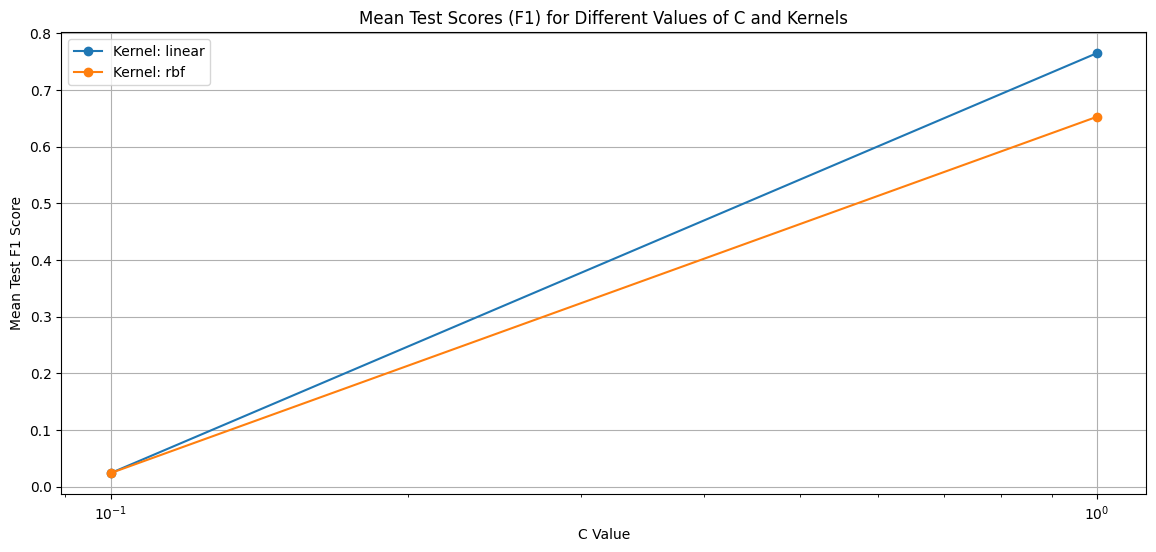

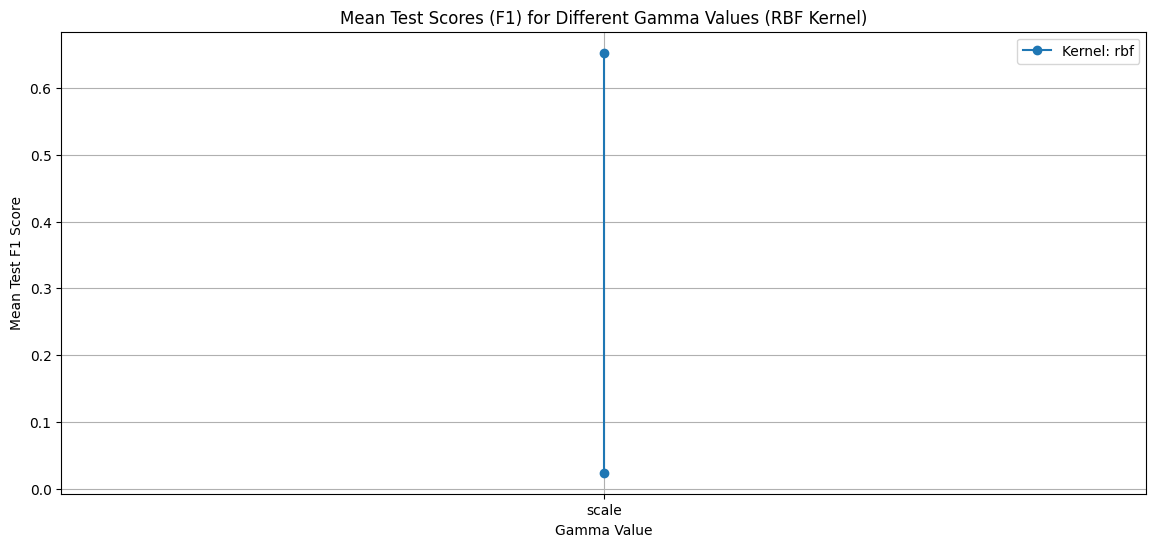

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, f1_score, accuracy_score

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all')
data, target = newsgroups.data, newsgroups.target

# Preprocess the data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X = vectorizer.fit_transform(data)

# Use a subset of the data to speed up training
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
X_train = X_train[:2000]  # Limit to 2000 samples for quicker training
y_train = y_train[:2000]

# Define a smaller parameter grid
param_grid = {
    'C': [0.1, 1],  # Reduced range for C
    'kernel': ['linear', 'rbf'],  # Fewer kernel types
    'gamma': ['scale']  # Single value to reduce combinations
}

# Custom scorer: Use F1-score as the evaluation metric
f1_scorer = make_scorer(f1_score, average='weighted')

# Initialize the SVC model
svc = SVC()

# Perform Grid Search with Cross-Validation using the custom scorer
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring=f1_scorer, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1):", grid_search.best_score_)

# Step 1: Extract the cross-validation results into a DataFrame
cv_results = pd.DataFrame(grid_search.cv_results_)

# Step 2: Visualize the mean test scores for different 'C' values and kernel types
plt.figure(figsize=(14, 6))

# Filter results for plotting: we only want 'linear' and 'rbf' kernels
kernels = ['linear', 'rbf']
for kernel in kernels:
    subset = cv_results[cv_results['param_kernel'] == kernel]
    plt.plot(subset['param_C'], subset['mean_test_score'], marker='o', label=f'Kernel: {kernel}')

plt.title('Mean Test Scores (F1) for Different Values of C and Kernels')
plt.xlabel('C Value')
plt.ylabel('Mean Test F1 Score')
plt.xscale('log')  # Use a logarithmic scale for better visualization of 'C'
plt.legend()
plt.grid(True)
plt.show()

# Step 3: Visualize the mean test scores for different 'gamma' values with 'rbf' kernel
plt.figure(figsize=(14, 6))

# Filter results to only show 'rbf' kernel scores by gamma
subset_rbf = cv_results[cv_results['param_kernel'] == 'rbf']
plt.plot(subset_rbf['param_gamma'], subset_rbf['mean_test_score'], marker='o', label='Kernel: rbf')

plt.title('Mean Test Scores (F1) for Different Gamma Values (RBF Kernel)')
plt.xlabel('Gamma Value')
plt.ylabel('Mean Test F1 Score')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Print all column names to find the appropriate column for plotting
print(cv_results.columns)


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_C', 'param_degree', 'param_gamma', 'param_kernel', 'params',
       'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy',
       'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy',
       'split0_test_f1_weighted', 'split1_test_f1_weighted',
       'split2_test_f1_weighted', 'mean_test_f1_weighted',
       'std_test_f1_weighted', 'rank_test_f1_weighted'],
      dtype='object')


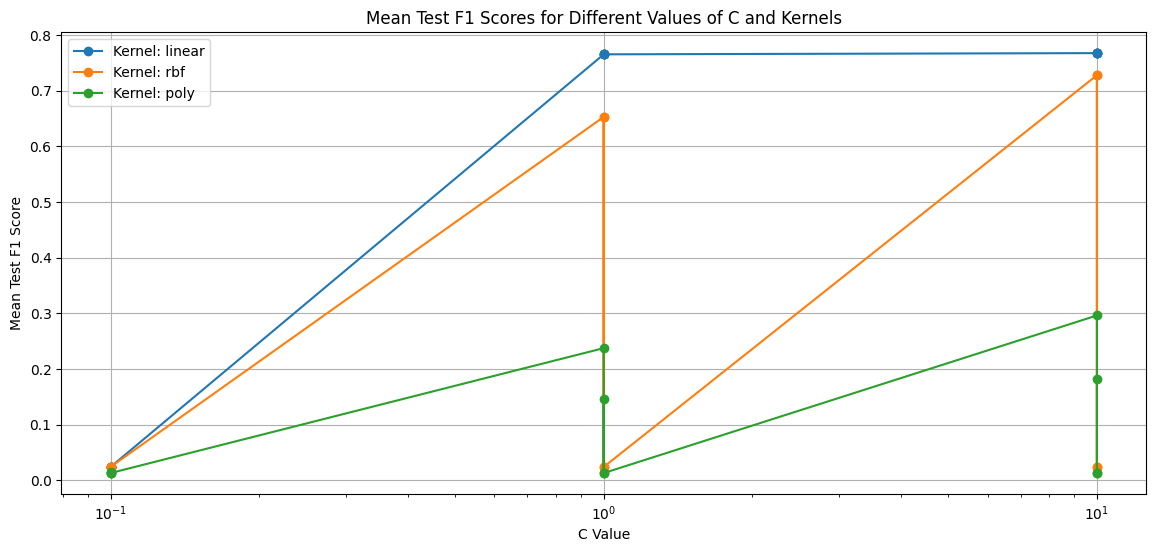

In [ ]:
# Use the actual column name found from the cv_results DataFrame
plt.figure(figsize=(14, 6))

# Replace 'mean_test_score_f1_weighted' with the correct column name
mean_f1_column = 'mean_test_f1_weighted'  # Update with the correct name if needed
for kernel in kernels:
    subset = cv_results[cv_results['param_kernel'] == kernel]
    plt.plot(subset['param_C'], subset[mean_f1_column], marker='o', label=f'Kernel: {kernel}')

plt.title('Mean Test F1 Scores for Different Values of C and Kernels')
plt.xlabel('C Value')
plt.ylabel('Mean Test F1 Score')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()


**Application of Semi-Supervised learning**

Test Set Accuracy (Semi-Supervised): 0.05
Test Set F1 Score (Semi-Supervised): 0.01


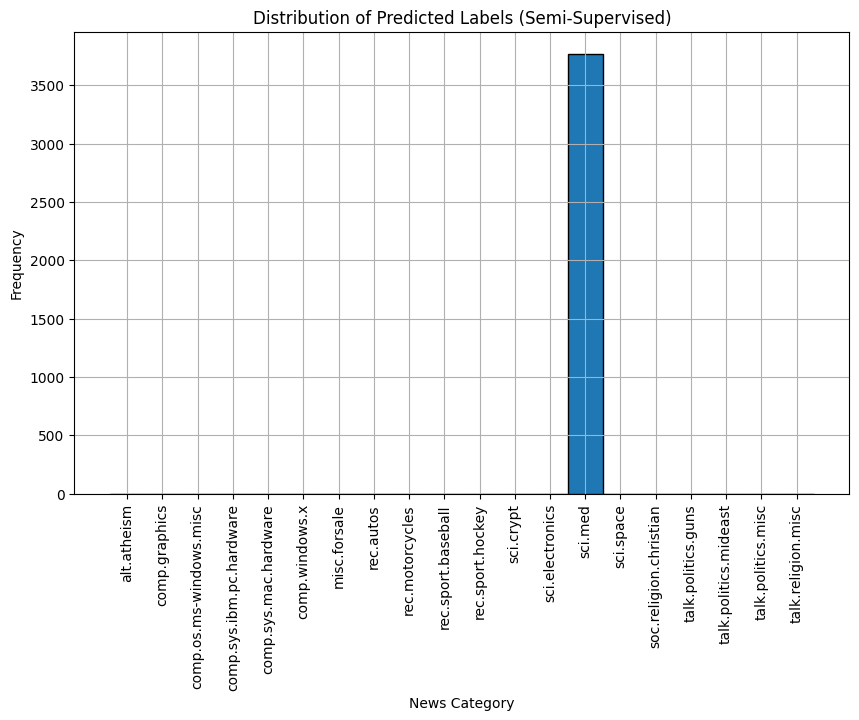

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all')
data, target = newsgroups.data, newsgroups.target

# Preprocess the data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X = vectorizer.fit_transform(data)

# Use a subset of the data to simulate semi-supervised learning
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
n_labeled_points = 500  # Number of initially labeled points
unlabeled_mask = np.full(y_train.shape, -1)
unlabeled_mask[:n_labeled_points] = y_train[:n_labeled_points]  # Keep some labels, set the rest as -1

# Train a Label Spreading model
label_spread = LabelSpreading(kernel='rbf', gamma=0.25)
label_spread.fit(X_train, unlabeled_mask)

# Predict on the test set
y_pred = label_spread.predict(X_test)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')
print(f'Test Set Accuracy (Semi-Supervised): {test_accuracy:.2f}')
print(f'Test Set F1 Score (Semi-Supervised): {test_f1:.2f}')

# Visualize the distribution of predicted labels for analysis
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=np.arange(0, len(newsgroups.target_names) + 1) - 0.5, edgecolor='black')
plt.xticks(np.arange(0, len(newsgroups.target_names)), newsgroups.target_names, rotation=90)
plt.title('Distribution of Predicted Labels (Semi-Supervised)')
plt.xlabel('News Category')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


LabelSpreading Results:


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning:

invalid value encountered in divide



Kernel: knn, Gamma: 0.1 -> Accuracy: 0.57, F1 Score: 0.56


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning:

invalid value encountered in divide



Kernel: knn, Gamma: 0.25 -> Accuracy: 0.57, F1 Score: 0.56


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning:

invalid value encountered in divide



Kernel: knn, Gamma: 0.5 -> Accuracy: 0.57, F1 Score: 0.56


/usr/local/lib/python3.10/dist-packages/sklearn/semi_supervised/_label_propagation.py:230: RuntimeWarning:

invalid value encountered in divide



Kernel: knn, Gamma: 1 -> Accuracy: 0.57, F1 Score: 0.56
Kernel: rbf, Gamma: 0.1 -> Accuracy: 0.05, F1 Score: 0.01
Kernel: rbf, Gamma: 0.25 -> Accuracy: 0.05, F1 Score: 0.01
Kernel: rbf, Gamma: 0.5 -> Accuracy: 0.05, F1 Score: 0.01
Kernel: rbf, Gamma: 1 -> Accuracy: 0.05, F1 Score: 0.01

LabelPropagation Results:
LabelPropagation -> Accuracy: 0.05, F1 Score: 0.01


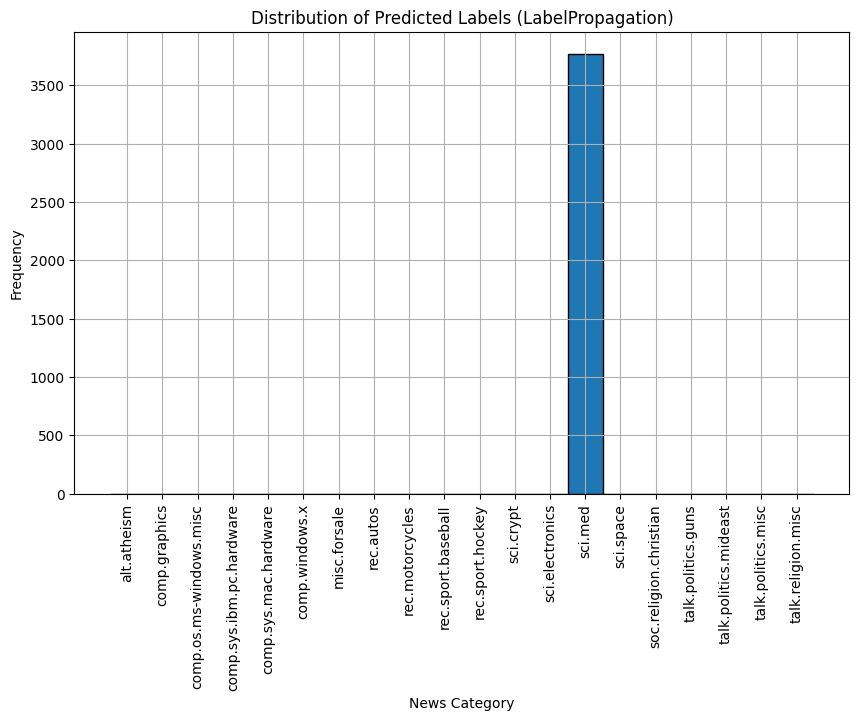

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all')
data, target = newsgroups.data, newsgroups.target

# Preprocess the data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X = vectorizer.fit_transform(data)

# Use a subset of the data for quicker training
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
n_labeled_points = 500  # Number of initially labeled points
unlabeled_mask = np.full(y_train.shape, -1)
unlabeled_mask[:n_labeled_points] = y_train[:n_labeled_points]  # Label only the first 500 points

# Tuning LabelSpreading with different gamma values and kernel types
gamma_values = [0.1, 0.25, 0.5, 1]
kernels = ['knn', 'rbf']

print("LabelSpreading Results:")
for kernel in kernels:
    for gamma in gamma_values:
        label_spread = LabelSpreading(kernel=kernel, gamma=gamma)
        label_spread.fit(X_train, unlabeled_mask)
        y_pred = label_spread.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"Kernel: {kernel}, Gamma: {gamma} -> Accuracy: {accuracy:.2f}, F1 Score: {f1:.2f}")

# Applying LabelPropagation
print("\nLabelPropagation Results:")
label_propagate = LabelPropagation(kernel='rbf', gamma=0.25)  # Gamma can be adjusted similarly
label_propagate.fit(X_train, unlabeled_mask)
y_pred_propagate = label_propagate.predict(X_test)

# Evaluate LabelPropagation
accuracy_propagate = accuracy_score(y_test, y_pred_propagate)
f1_propagate = f1_score(y_test, y_pred_propagate, average='weighted')
print(f"LabelPropagation -> Accuracy: {accuracy_propagate:.2f}, F1 Score: {f1_propagate:.2f}")

# Visualize the distribution of predicted labels for LabelPropagation
plt.figure(figsize=(10, 6))
plt.hist(y_pred_propagate, bins=np.arange(0, len(newsgroups.target_names) + 1) - 0.5, edgecolor='black')
plt.xticks(np.arange(0, len(newsgroups.target_names)), newsgroups.target_names, rotation=90)
plt.title('Distribution of Predicted Labels (LabelPropagation)')
plt.xlabel('News Category')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


**Comparision**

               Model  Accuracy  F1 Score
0                SVC  0.921220  0.921828
1    Label Spreading  0.051459  0.005037
2  Label Propagation  0.051459  0.005037


<Figure size 1000x600 with 0 Axes>

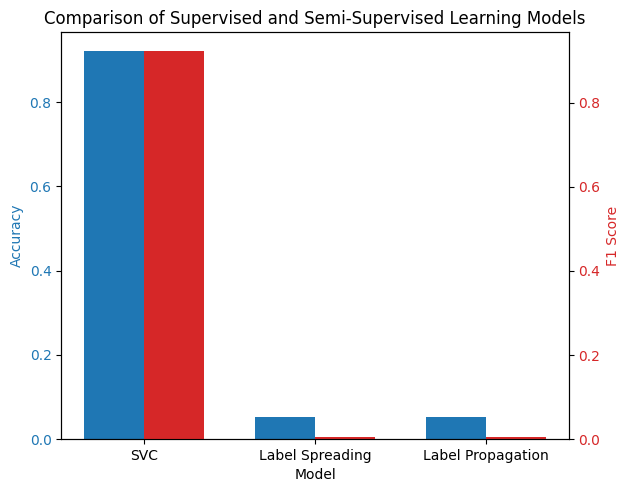

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.semi_supervised import LabelSpreading, LabelPropagation
from sklearn.metrics import accuracy_score, f1_score

# Load the dataset
newsgroups = fetch_20newsgroups(subset='all')
data, target = newsgroups.data, newsgroups.target

# Preprocess the data using TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5)
X = vectorizer.fit_transform(data)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)

# Supervised Learning: Train SVC
svc_model = SVC(C=10, kernel='linear', degree=3, gamma='scale')  # Best params from earlier
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

# Evaluate the SVC model
svc_accuracy = accuracy_score(y_test, y_pred_svc)
svc_f1 = f1_score(y_test, y_pred_svc, average='weighted')

# Semi-Supervised Learning: Prepare unlabeled data
n_labeled_points = 500  # Number of initially labeled points
unlabeled_mask = np.full(y_train.shape, -1)
unlabeled_mask[:n_labeled_points] = y_train[:n_labeled_points]  # Label only the first 500 points

# Label Spreading
label_spread = LabelSpreading(kernel='rbf', gamma=0.25)
label_spread.fit(X_train, unlabeled_mask)
y_pred_spread = label_spread.predict(X_test)

# Evaluate Label Spreading
spread_accuracy = accuracy_score(y_test, y_pred_spread)
spread_f1 = f1_score(y_test, y_pred_spread, average='weighted')

# Label Propagation
label_propagate = LabelPropagation(kernel='rbf', gamma=0.25)
label_propagate.fit(X_train, unlabeled_mask)
y_pred_propagate = label_propagate.predict(X_test)

# Evaluate Label Propagation
propagate_accuracy = accuracy_score(y_test, y_pred_propagate)
propagate_f1 = f1_score(y_test, y_pred_propagate, average='weighted')

# Summary of results
results = {
    'Model': ['SVC', 'Label Spreading', 'Label Propagation'],
    'Accuracy': [svc_accuracy, spread_accuracy, propagate_accuracy],
    'F1 Score': [svc_f1, spread_f1, propagate_f1]
}

results_df = pd.DataFrame(results)

# Print results
print(results_df)

# Visualization of results
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df['Model']))
width = 0.35

# Bar plots for accuracy and F1 score
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x - width/2, results_df['Accuracy'], width, label='Accuracy', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('F1 Score', color=color)
ax2.bar(x + width/2, results_df['F1 Score'], width, label='F1 Score', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Set model names on x-axis
ax1.set_xticks(x)
ax1.set_xticklabels(results_df['Model'])

fig.tight_layout()  # to make sure there's no clipping of ylabel
plt.title('Comparison of Supervised and Semi-Supervised Learning Models')
plt.show()
